In [1]:
#from libs.edgelistParser import edgelistParser
#from libs.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from libs.page_rank import approximateSimrank, localPageRank
#from libs.plotNetwork import plotNetworkClusters

# use cython compiled modules for faster execution
from scripts.cython.edgelistParser import edgelistParser
from scripts.cython.utils import list2matrix, getInOutDegree, transposeEdgelist, reorderEdgelist
#from scripts.cython.pageRank import approximateSimrank, localPageRank
from scripts.cython.plotNetwork import plotNetworkClusters

from scripts.cpp_libs.pageRankCpp import cppLocalPageRank as localPageRank

import numpy as np
from matplotlib import pyplot as plt
import heapq as hq
import networkx as nx

In [2]:
# load the Facebook dataset
A, N, original_idxs = edgelistParser("datasets/facebook/0.edges", "raw_list")

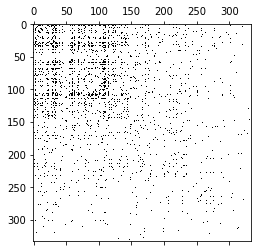

In [3]:
A_mat = list2matrix(A)
plt.figure()
plt.spy(A_mat)
plt.show()

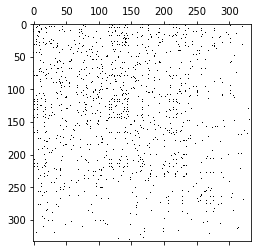

In [4]:
# generate the L matrix
L = localPageRank(A, c=0.85, return_only_neighbours=True)
L_mat = list2matrix(L)
plt.figure()
plt.spy(L_mat)
plt.show()

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


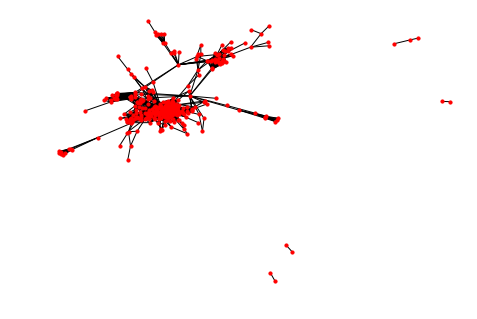

In [5]:
# test the network plot
g = nx.Graph(A_mat)
plt.figure()
nx.draw_spring(g, node_size=10)
plt.show()

In [6]:
# the function computes the network clustering
def cluster(L_norm, centroids, alpha, A, plot_end=True, plot_steps=False):  
    # initialize the output vector with the clusters
    clusters = - np.ones(len(L_norm))
    
    if plot_steps:
        pos = None
        colors = None
    
    # initialize the heap queues related to the clusters
    queues = []
    
    # insert centroids in the queues, e.g. (expansions, (node, rank))
    for i in range(centroids.size):
        queue = []
        hq.heappush(queue, (0, (centroids[i], 1)))
        queues.append(queue)
        
        # set the centroid cluster
        clusters[centroids[i]] = centroids[i]
    
    # iterate until all the nodes are assigned to the clusters   
    exit_ext = False
    while not exit_ext:
        #
        cumulative_length = 0
        for queue in queues:
            # assign the new expansions
            for i, node in enumerate(queue):
                # ensure at least one expansion per node
                expansions = max(1, np.round(alpha*node[1][1])) # TODO: eventually change the round function
                
                # modify the queue element with the new expansions
                queue[i] = (
                    - expansions,
                    (node[1][0], node[1][1])
                )
            
            # restore the queue
            hq.heapify(queue)
            
            #print(queue)
        
            # expand the cluster boundary toward the high ranked nodes
            exit_int = False
            while (not exit_int) and len(queue)>0: # TODO: check correctness
                # pop a node that should be expanded 
                node = hq.heappop(queue)
                #print("popped")
                
                # check the termination condition
                expansions_opp = node[0]
                if expansions_opp==0:
                    # no more nodes to expand
                    exit_int = True
                else:
                    #print("else")
                    # reduce the remained number of expansions
                    expansions_opp += 1
                    
                    # TODO: exploit the edgelist to enhance efficiency and ensure correctness
                    # expand the neighbourhood and assign the new expansions
                    #print("where", np.where(L[node[1][0],:]>0)[0])
                    for edge in L_norm[node[1][0]]:
                        #print(neighbour)
                        neighbour = edge[0]
                        # assign the node to the cluster
                        if clusters[neighbour]<0:
                            #print("assigned")
                            clusters[neighbour] = clusters[node[1][0]]
                            
                            # add the node to the queue
                            rank = edge[1]
                            hq.heappush(
                                queue,
                                (
                                    np.round(expansions_opp*rank), # TODO: eventually change the round function
                                    (neighbour, rank)
                                )
                            )
                            
            # TODO: check
            cumulative_length += len(queue) 
        
        exit_ext = cumulative_length==0
    
        # test plot <-> CLUSTERS SHOULD BE A LIST!
        if plot_steps:
            pos, colors = plotNetworkClusters(A, list(clusters.astype(int)), 5, draw_edges=False, pos=pos, colors=colors)
        
    if plot_end and not plot_steps:
        plotNetworkClusters(A, list(clusters.astype(int)), 5, draw_edges=False)
    
    # return the vector with the clusters
    return clusters

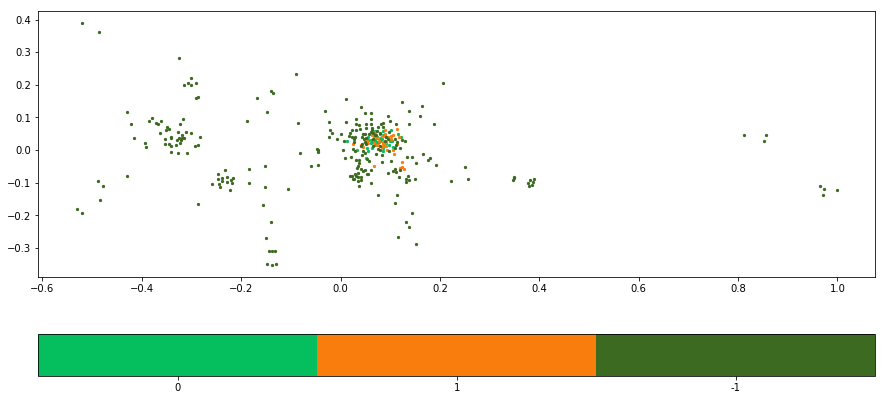

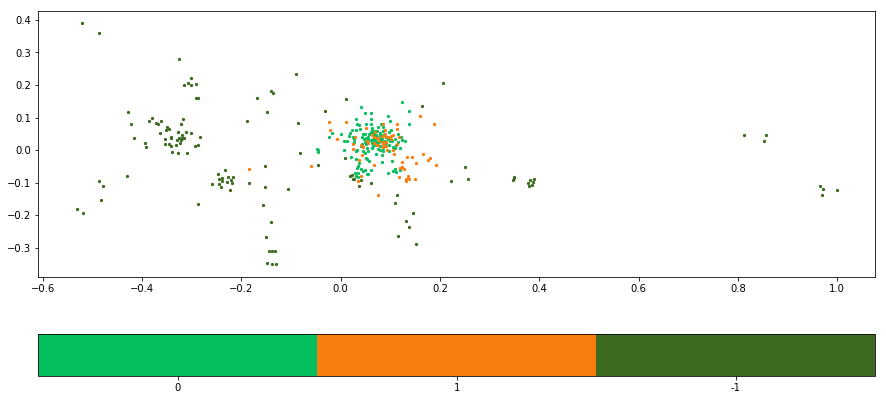

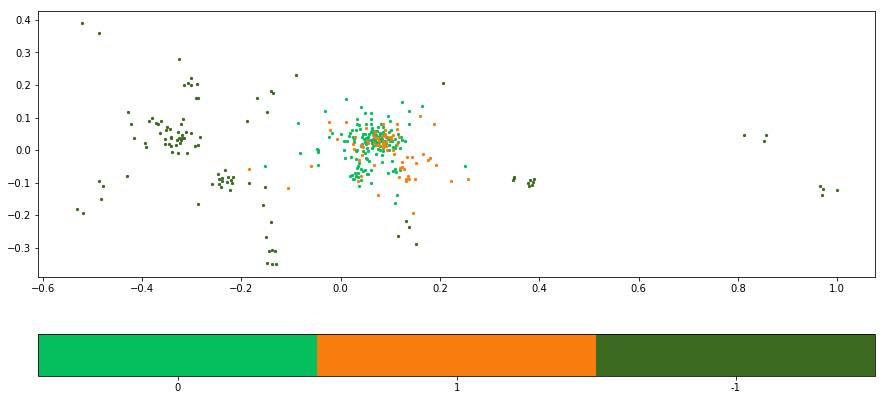

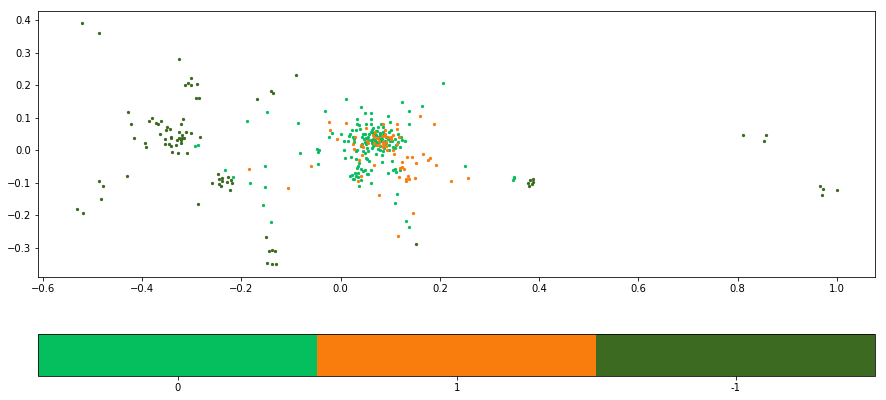

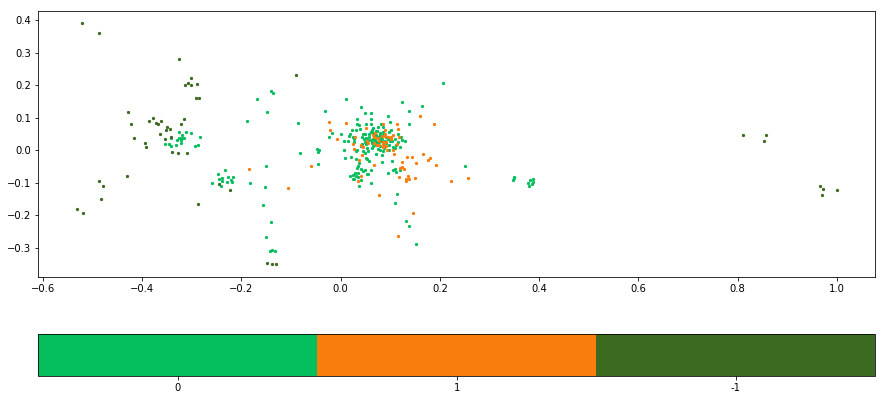

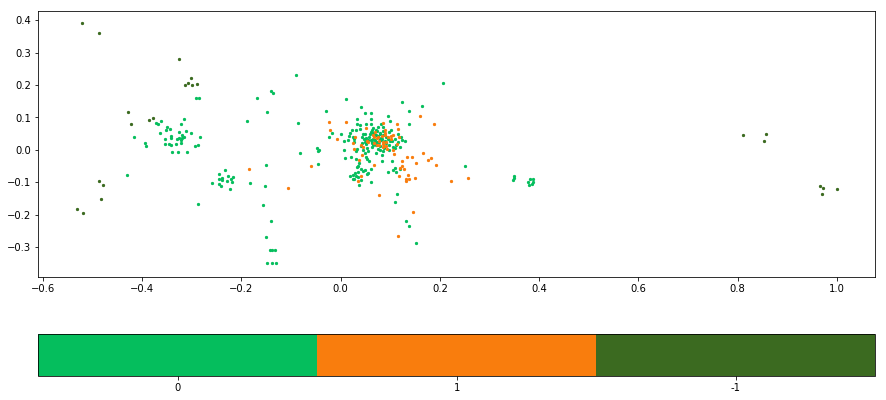

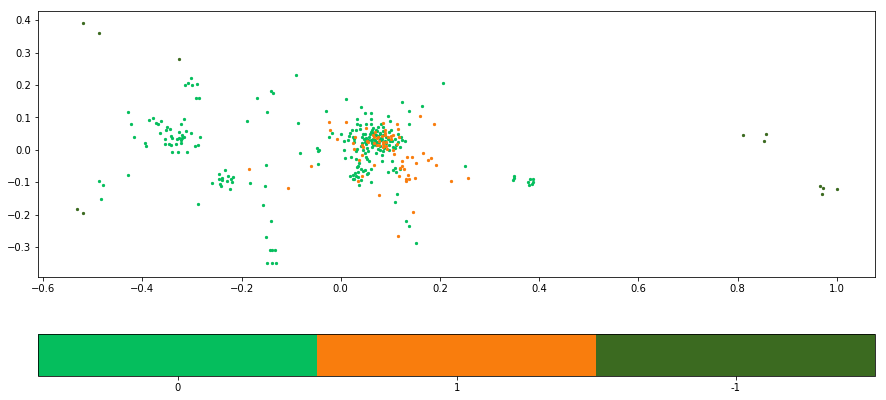

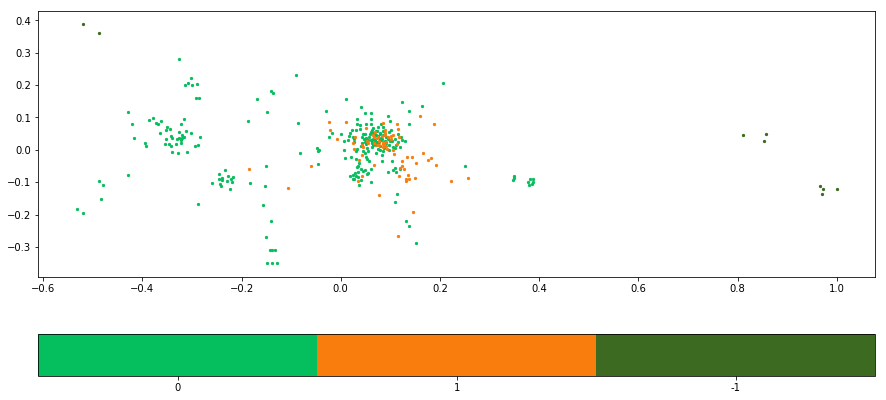

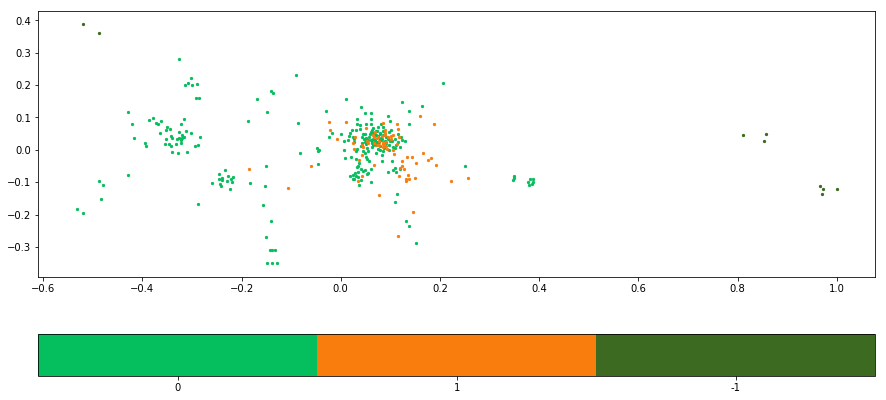

[ 0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.
  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.
  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0. -1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0. -1

In [7]:
# normalize the rows of L
#L_norm = L/np.sum(L, 1)
#L_norm[np.logical_not(np.isfinite(L_norm))] = 0

# test the clustering algorithm
#print(cluster(L, np.array([59, 134, 101, 88, 180, 148, 299, 7, 331, 302]), 5, A_mat, plot_steps=True))
print(cluster(L, np.array([0,1]), 5, A_mat, plot_steps=True))
#clusters = cluster(L, np.array(idxs), 5, A_mat)
#_ = plotNetworkClusters(A_mat, clusters, 5, draw_edges=False, pos=None)

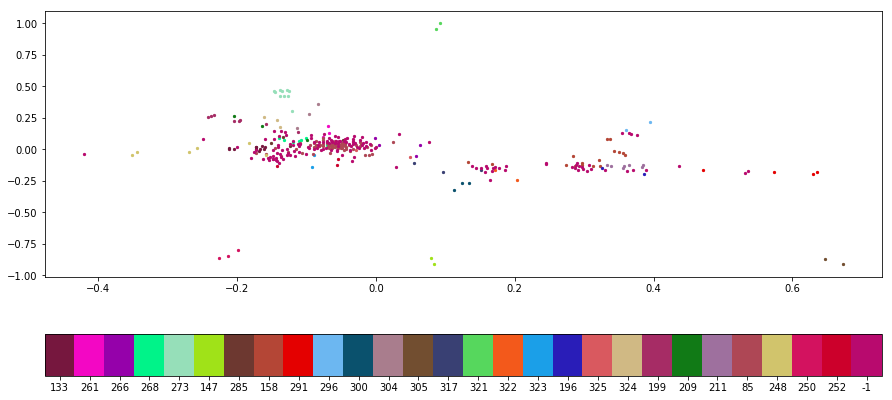

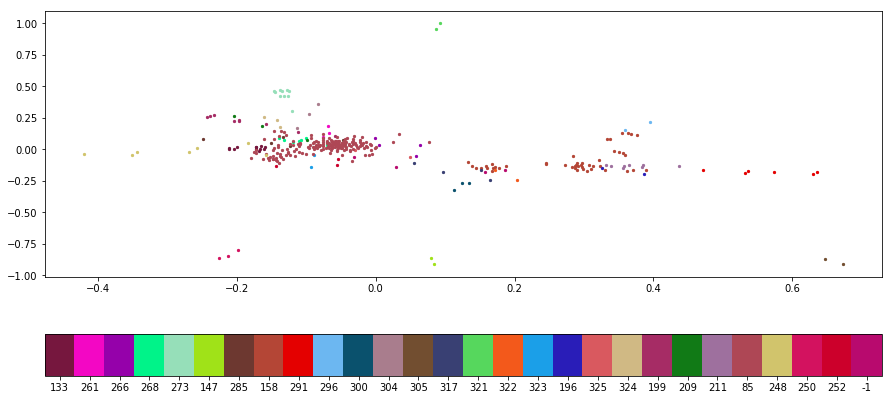

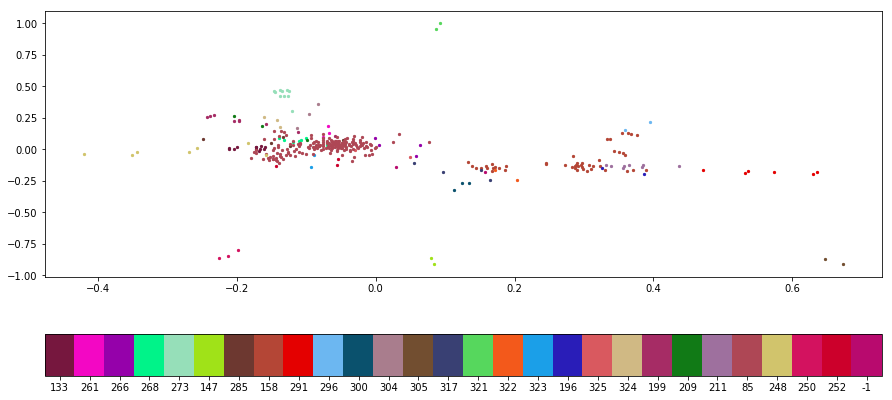

[ 85.  85.  85.  85.  85.  85.  85.  85.  85.  85.  85.  85.  85. 325.
  85.  85.  85. 158.  85.  85.  85. 133.  85.  85. 266.  85.  85.  85.
  85.  85.  85.  85.  85.  85.  85.  85.  85.  85.  85. 133.  85.  85.
 268. 133.  85.  85. 273.  85.  85. 158.  85. 158. 317. 158.  85.  85.
  85.  85.  85.  85.  85. 273.  85.  85.  85.  85.  85. 133.  85.  85.
  85.  85.  85.  85.  85.  85. 158.  85.  85.  85.  85. 133.  85. 158.
  85.  85.  85. 158. 248.  85.  85.  85.  85. 291.  85.  85.  85. 158.
 133. 158. 158.  85. 133.  85. 268.  85. 209.  85.  85.  85.  85.  85.
 196. 158. 211. 268.  85.  85.  85.  85.  85.  85.  85.  85.  85. 268.
  85.  85. 133.  85. 317.  85.  85. 133.  85.  85.  85.  85.  85.  85.
  85.  85.  85. 304.  85.  85. 158. 147. 158. 158. 158. 158.  85. 133.
  85. 158.  85.  85. 158.  85.  85. 211. 273.  85. 323. 285. 291.  85.
 211. 273. 199.  85.  85. 268. 273. 158.  85.  85.  85. 158. 158.  85.
  85.  85. 248. 158.  85. 273. 158.  85.  85.  85. 199.  85.  85. 324.
 196. 

In [8]:
print(cluster(L, np.array(
    [85, 158, 291, 248, 250, 199, 209, 304, 273, 321, 147, 305, 300, 133, 252, 211, 268, 324, 261, 317, 266, 285, 296, 325, 196, 323, 322]
    #[379, 373, 414, 726, 856, 455, 104, 974, 949, 803, 805, 981, 786, 653, 672, 322, 985, 992, 897, 975, 388, 944, 1018, 998, 152, 1014, 1007, 920, 1029, 929]
), 5, A_mat, plot_steps=True))